In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import os
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', None)

In [2]:
# if subject==None:
# subject = input("Please input subject number in XX format: ")
subject='02'
# Load settings file
settings = pd.read_csv(f"../settings/emg_settings/S{subject}_emg_settings.csv", header=None)
inputs_path = settings.iloc[0,1]
outputs_path = settings.iloc[1,1]

## Functions

In [5]:
def get_emg_files():
    inputs_names = os.listdir(inputs_path)
    norm_file = f"S{subject}_EMG_norm.csv"
    inputs_names.remove(norm_file)
    output_files = list(map(lambda x:f"{outputs_path}{x}", inputs_names))
    output_files = list(map(lambda x:x.replace("_EMG","_features"), output_files))
    return norm_file, inputs_names, output_files

def load_emg_data(emg_file):
    emg = pd.read_csv(f"{inputs_path}{emg_file}", header=12)
    emg.columns = emg.columns.str.replace(": EMG.*", "", regex=True)
    emg.columns = emg.columns.str.replace("Trigno IM ", "", regex=True)
    emg.columns = emg.columns.str.replace("X [s]", "time", regex=False)
    emg.set_index("time", inplace=True)
    return emg

def apply_filter(emg, order=4, lowband=20, highband=450):
    fs = 1/0.0009 # Hz
    low_pass = lowband/(fs*0.5)
    hig_pass = highband/(fs*0.5)
    b, a = butter(N=order, Wn=[low_pass, hig_pass], btype="bandpass")
    return filtfilt(b, a, emg)

def normalize_emg(filtered_emg, norm_file):
    """
    Make sure data is filtered with zero mean before normalization
    """
    # Load the data that will be used for normalizing
    emg_normalizer = load_emg_data(norm_file)
    # Filter the data
    emg_normalizer = emg_normalizer.apply(apply_filter)
    # Remove mean
    emg_normalizer = emg_normalizer-emg_normalizer.mean()
    # Create a pandas dataset that will received the normalized data
    normalized_emg = pd.DataFrame()
    for col in filtered_emg.columns:
        # Create standard scaler object
        scaler=MinMaxScaler(feature_range=(-1,1))
        # fit the scaler to the normailer data
        scaler.fit(np.reshape(emg_normalizer[col].values,(-1,1)))
        #get one sensor values at the time
        filtered_emg_col = filtered_emg[col].values
        # Normalize the column and updated normalized emg dataframe values
        normalized_emg[col] = scaler.transform(np.reshape(filtered_emg_col, (-1,1)))
    return normalized_emg

def process_emg_signal(emg, norm_file):
    # filter the signals
    filtered_emg = emg.apply(apply_filter)
    # Remove The mean
    filtered_emg = filtered_emg-filtered_emg.mean()
    # Normalize signals
    norm_emg = normalize_emg(filtered_emg, norm_file)
    # Get signals gradient
    return norm_emg

def plot_all_emg(emg, file_name=None):
    m = 2
    n = int(len(emg.columns)/2)
    for i in range(n):
        plt.subplot(n,m,i+1)
        plt.plot(emg.index, emg.iloc[:,2*i], emg.index, emg.iloc[:,2*i+1])
    plt.suptitle(file_name)
    plt.show()

### Features Functions

In [12]:
# Define the RMS function
from math import sqrt
import statistics

def get_AR_coeffs(data, num_coeff = 6):
    model = AutoReg (data, lags=num_coeff, )#old_names=True)
    model_fit = model.fit()
    return model_fit.params

def get_RMS(data):
    return sqrt(sum(n*n for n in data)/len(data))

def get_MAV(data):
    return sum(abs(n) for n in data)/len(data)

def zero_crossing(data):
    zero_crossings = np.where(np.diff(np.signbit(data)))[0] # returns the indexes of where ZC appear
    return len(zero_crossings)

def wave_length(data):
    return np.sum(abs(np.diff(data)))

In [7]:
def create_empty_array(DEMG, col_num=1, factor=10):
    array = np.empty((int(len(DEMG)/factor), col_num))
    array[:] = np.nan
    return array

def get_features(DEMG):
    step = 0.05
    dataset = pd.DataFrame()
    time_limit = max(DEMG.index)
    print(f"time_limit: {time_limit}s")
    for EMG_num in range(len(DEMG.columns)):
        start = 0
        end = 0.1
        coeff = []
#         RMS = []
        MAV = []
        ZC = []
        WL = []
        EMG_label = f"sensor {EMG_num+1}"
        sensor_data = DEMG[EMG_label]
################################################################################################
        while (end<time_limit):
            window_data = sensor_data[(DEMG.index>=start) & (DEMG.index < end)].to_numpy()
#             # Get the RMS
#             RMS.append(get_RMS(window_data))
            # Get the MAV
            MAV.append(get_MAV(window_data))
            # Get Zero-Crossing
            ZC.append(zero_crossing(window_data))
            # Get Wave length
            WL.append(wave_length(window_data))
            #Get the AR coefficients
            coeff.append(get_AR_coeffs(window_data))
            # Update window
            start = start + step
            end = end + step
################################################################################################
        coeff = np.array(coeff)
#         RMS = np.array(RMS)
        ZC = np.array(ZC)
        WL = np.array(WL)
        MAV = np.array(MAV)
        dataset_temp =  pd.DataFrame({f'DEMG{EMG_num+1}_AR1':coeff[:,1], f'DEMG{EMG_num+1}_AR2':coeff[:,2], 
                                      f'DEMG{EMG_num+1}_AR3':coeff[:,3],f'DEMG{EMG_num+1}_AR4':coeff[:,4], 
                                      f'DEMG{EMG_num+1}_AR5':coeff[:,5], f'DEMG{EMG_num+1}_AR6':coeff[:,6],
                                      f'DEMG{EMG_num+1}_ZC': ZC, f'DEMG{EMG_num+1}_WL': WL,
                                      f'DEMG{EMG_num+1}_MAV': MAV})
        dataset = pd.concat([dataset, dataset_temp], axis=1)
        print(f"{EMG_label} done")

    dataset['time'] = [np.around(step*i, 2) for i in range(len(dataset))]
    dataset.set_index("time", inplace=True)
    dataset.describe()
    return dataset
    
def plot_MAV(dataset, emg_file):
    RMS_columns = [f'DEMG{i+1}_MAV' for i in range(12)]
    RMS_data = dataset[RMS_columns]
    plot_all_emg(RMS_data, emg_file)

In [11]:
def emg_to_features():
    norm_file, inputs_names, output_files = get_emg_files()
    for emg_file, output_file in zip(inputs_names, output_files):
        emg = load_emg_data(emg_file)
        DEMG = process_emg_signal(emg, norm_file)
    #     plot_all_emg(DEMG, emg_file)
    #     filtered_emg.describe()
        dataset = get_features(DEMG)
        plot_MAV(dataset, emg_file)
        plt.show();
        dataset.to_csv(output_file)

time_limit: 56.9988s


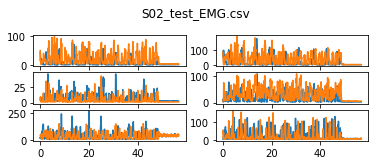

time_limit: 182.9988s


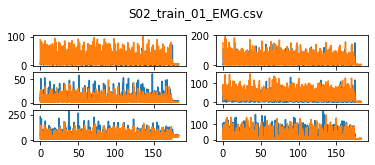

time_limit: 182.9988s


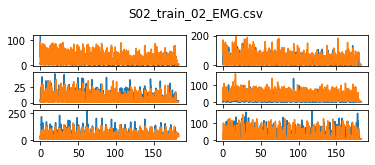

time_limit: 195.9984s


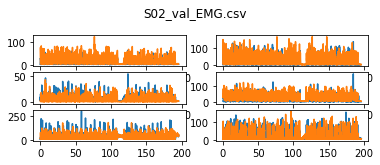

Wall time: 11min 53s


In [12]:
%%time
emg_to_features()